In [1]:
cd ../../../..

/Users/jbbutler129/Google Drive (butlerj@berkeley.edu)/Classes/215A/final_project/rule-vetting


In [2]:
%pwd

'/Users/jbbutler129/Google Drive (butlerj@berkeley.edu)/Classes/215A/final_project/rule-vetting'

# Cleaning Steps (*for clean_dataset_11_24.csv*)

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# useful helper functions

def make_missing_plot(df):
    
    col_dict = {}

    for col in list(df):
    
        col_dict[col] = sum(np.isnan(np.array(df[col])))/len(df)

    col_names = list(col_dict.keys())
    proportions = list(col_dict.values())

    name = 'nan_props.png'

    plt.figure(dpi=250, figsize=(17, 7))
    plt.bar(col_names, proportions)
    plt.ylabel('proportion', fontsize = 16)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
    plt.title('Proportion of NaN for each Variable (no response)', fontsize = 20)
    
def make_missing_contingency(df, varlist):

    subset = df[varlist]
    subset = subset.fillna('missing')
    
    first_col = subset[varlist[0]]
    other_cols = []
    
    for col in list(subset.drop(varlist[0], axis = 1)):
        other_cols.append(subset[col])

    table = pd.crosstab(first_col, other_cols, dropna = False)
    
    return table



In [4]:
tbi_df = pd.read_csv("data/tbi_pecarn/raw/TBI PUD 10-08-2013.csv")

### Step 1: Remove variables which have nothing to do with our problem (uncontroversial choices)


#### List of Variables:

List 1:

*EmplType*
*Certification*

Justification: probably not a huge systematic difference between who fills out the form. This would be an issue if there were systematic differences that we would also expect in future data, but we can't tell. Domain expert also says not a big deal, and many of the questions are fairly objective anyway, so these variables are unimportant

List 2:

*InjuryMech*

Justification: a 10 way categorical variable would probably not be super helpful for a future data situation, maybe just keep the severity of the injury mechanism (although generalizability to a future data situation might be tough, but I think the paper uses this variable soo)

List 3:

*CTForm1*
*IndAge*
*IndAmnesia*
*IndAMS*
*IndClinSFx*
*IndHA*
*IndHema*
*IndLOC*
*IndMech*
*IndNeuroD*
*IndRqstMD*
*IndRqstParent*
*IndRqstTrauma*
*IndSeiz*
*IndVomit*
*IndXraySFx*
*IndOth*
*CTSed*
*CTSedAgitate*
*CTSedAge*
*CTSedRqst*
*CTSedOth*

Justification: these variables all represent details relevant to obtaining a CT scan for an individual (reasons why, whether they were sedated, etc.) This information is not relevant for our problem, so we just drop.

List 4:

*AgeTwoPlus*

Justification: AgeTwoPlus is just some variable that we could make on our own. Would be useful to eventually subset observations by this, but maybe not entirely necessary, so for the purposes of having a clean dataset with everything in it (before making judgment calls to subset for different models), we'll just get rid of this for now (less to worry about in cleaning/EDA)

List 5:

*Observed*
*EDDisposition*
*CTDone*
*EDCT*
*PosCT*
*Finding1*
...
*Finding23*

Justification: this is all info on what was found in the CT scans/what ended up being done with the patient (operating room, admitted into hospital, etc). All of this information would be known on future data well after our algorithm is to be used, so we exclude this information.

In [5]:
list1 = ['EmplType', 'Certification']
list2 = ['InjuryMech']

# grab all of the CT/Ind variables
list3 = []
for col in tbi_df.keys():
    if 'Ind' in col or 'CT' in col:
        list3.append(col)

list4 = ['AgeTwoPlus', 'AgeInMonth']

# grab all of the Finding variables
list5 = ['Observed', 'EDDisposition']

for col in tbi_df.keys():
    if 'Finding' in col:
        list5.append(col)

total_rem = list1 + list2 + list3 + list4 + list5

tbi_df_step1 = tbi_df.drop(total_rem, axis=1)

### Step 2: Remove variables with really high missingness (that we don't care about)

In [6]:
tbi_df_step2 = tbi_df_step1.drop(['Ethnicity', 'Dizzy'], axis = 1)

### Step 3: Remove observations with GCS < 14


Justification: the paper does this as well, so as to be best comparable to the baseline results from the paper. Also, Rob told us GCS < 14 means you're pretty wacked out, and we're interested in predicting on children in a borderline case (for which we could possibly avoid a CT scan). Also, drop this column once we're done because we don't super care about it (can remake it if we really wanted to with GCS info)

In [7]:
tbi_df_step3 = tbi_df_step2[tbi_df_step2['GCSGroup'] == 2]
tbi_df_step3 = tbi_df_step3.drop(['GCSGroup'], axis = 1)

### Step 4: Remove Missing Observations Among the Response Outcomes

Remove any observation with missing data for any of the 4 response outcomes, and then impute the proper response for PosIntFinal.

Justification: PosIntFinal has a lot of missing values for which responses for the 4 outcomes are provided, so we would be throwing out data that we could impute. Additionally, some obs have PosIntFinal values despite one of the constituent variables being missing. So, doesn't make sense to keep these observations since we don't know the final outcome since one of the consitutent variables is missing. So, take these observations out, and then impute the rest into PosIntFinal.

In [8]:
tbi_df_step4 = tbi_df_step3.dropna(subset = ['DeathTBI', 'Intub24Head', 'Neurosurgery', 'HospHead'])
tbi_df_step4['PosIntFinal'].fillna(0, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### Step 5: Make a New Column ciTBI, without the hospitalization condition

In [11]:
sset = tbi_df_step4[['DeathTBI', 'Intub24Head', 'Neurosurgery']]
new_outcome = np.zeros(len(sset))
new_outcome[np.sum(np.array(sset), 1) > 0] = 1

tbi_df_step5 = tbi_df_step4.assign(PosIntFinalNoHosp = new_outcome)


### Step 6: Impute/drop GCS Verbal/Motor/Eye Scores

Seems like of the GCS = 14 scores, only 19 of them are missing all three, and about 23 observations are missing at least one value. But this is out of 1200 observations, so we can just get rid of these, probably not going to hurt us (judgment call!)

In [14]:
tbi_df_step6 = tbi_df_step5.copy()
tbi_df_step6.drop(tbi_df_step6[(tbi_df_step6['GCSTotal'] == 14) & ((tbi_df_step6['GCSVerbal'].isnull()) | (tbi_df_step6['GCSMotor'].isnull()) | (tbi_df_step6['GCSEye'].isnull()))].index, inplace = True)


Then, impute the missing values among GCS = 15 scores to just be the full points for each category.

In [15]:
tbi_df_step6.loc[(tbi_df_step6['GCSTotal'] == 15) & tbi_df_step6['GCSVerbal'].isnull(), 'GCSVerbal'] = 5
tbi_df_step6.loc[(tbi_df_step6['GCSTotal'] == 15) & tbi_df_step6['GCSMotor'].isnull(), 'GCSMotor'] = 6
tbi_df_step6.loc[(tbi_df_step6['GCSTotal'] == 15) & tbi_df_step6['GCSEye'].isnull(), 'GCSEye'] = 4

Also seems like there were a few wonky observations (like GCS score was 15, but they had lower than optimal scores in some of the individual categories, so what I will do is just drop those observations). Judgment call!

In [16]:
tbi_df_step6.drop(tbi_df_step6[(tbi_df_step6['GCSTotal'] == 15) & ((tbi_df_step6['GCSVerbal'] < 5) | (tbi_df_step6['GCSMotor'] < 6) | (tbi_df_step6['GCSEye'] < 4))].index, inplace = True)


That seems to have mostly solved the issues, but there is still one big issue: one observation has full 15 score among the three categories, but is labelled as 14. Let's drop it, but this is another judgment call

In [19]:
tbi_df_step6.drop(tbi_df_step6[(tbi_df_step6['GCSTotal'] == 14) & ((tbi_df_step6['GCSVerbal'] == 5) & (tbi_df_step6['GCSMotor'] == 6) & (tbi_df_step6['GCSEye'] == 4))].index, inplace = True)


### Step 7: Impute/drop based on Paralyzed/Sedated/Intubated

Looks like a lot of missing values. Let's just get rid of any observation that has a 1 in it (a little too intense for our population; we don't care about people who were sedated, paralyzed, or intubated).

Also remove the missing value rows because we can't particularly tell whether they were paralyzed sedated or not.

JUDGMENT CALL! Could also keep these in and see if the results change (for example, keeping individuals who were paralyzed, sedated, or intubated, maybe a baby could have been sedated to be evaluated but is otherwise fine? could impact results..)

In [20]:
tbi_df_step7 = tbi_df_step6.copy()

tbi_df_step7.drop(tbi_df_step7.loc[(tbi_df_step7['Paralyzed'] == 1) | (tbi_df_step7['Sedated'] == 1) | (tbi_df_step7['Intubated'] == 1)].index, inplace = True)
tbi_df_step7.drop(tbi_df_step7.loc[(tbi_df_step7['Paralyzed'].isnull()) | (tbi_df_step7['Sedated'].isnull()) | (tbi_df_step7['Intubated'].isnull())].index, inplace = True)
tbi_df_step7.drop(['Sedated', 'Paralyzed', 'Intubated'], axis = 1, inplace = True)


### Step 8: Impute/drop based on AMS

Seems like from this that all of the missing AMS observations are actually missing for all of the other variables as well (subvariables, all have label 92 indicating a missing value or no AMS). So, let's drop these observations since AMS is an important predictor and we don't want to bastardize this for our classifier (also only ~300 observations, not the biggest deal)

In [24]:
tbi_df_step8 = tbi_df_step7.copy()
tbi_df_step8.drop(tbi_df_step8.loc[tbi_df_step8['AMS'].isnull()].index, inplace = True)

### Step 9: Impute/drop based on OSI

Once again, seems like all of the missing values in this column cannot be imputed since these values are also missing all of their subvariable info. So, we drop (only 181 observations, but this is another JUDGMENT CALL since domain expert says this variable should probably not be important at all, alternative to this judgment call could be to just drop the column but keep the obs with missing values anyways, and fit the models without this column and see if the results change)

In [25]:
tbi_df_step9 = tbi_df_step8.copy()
tbi_df_step9.drop(tbi_df_step9.loc[tbi_df_step9['OSI'].isnull()].index, inplace = True)

### Step 10: Impute/drop based on Hema variables

Going to drop all of the observations with missing Hema variables, since we don't have that information. I think we are interested in seeing how hematoma might predict TBI, specifically location (could be interesting, to have this and to binarize and see if different sizes/locations could influence). Judgment call: what if we still deleted the empty Hema variables since those seemed important, but did not delete the observations with missing values in the other columns (since we would have the main information in Hema already present) and just predict using Hema. Would we get better results? Different results?

In [26]:
tbi_df_step10 = tbi_df_step9.copy()
tbi_df_step10.drop(tbi_df_step10.loc[(tbi_df_step10['Hema'].isnull()) | (tbi_df_step10['HemaLoc'].isnull()) | (tbi_df_step10['HemaSize'].isnull())].index, inplace = True)

### Step 11: Impute/drop based on skull fracture palp variables

JUDGMENT CALL: it seems important to include if you have an unclear exam for a palpable skull fracture (probably will come up a lot in future situations, so important not to subset this out of the population). Since we are trying to predict low risk of clinically important TBI (vs. not low risk) we should probably frame the variable into a binary variable where one choice could correspond to something that would not indicate a TBI (no trauma) vs something that could indicate a TBI (unclear exam or yes trauma). So, turn the 2 into 1s for SFxPalp. The variable means 1 if they did not not observe a fracture, and 0 if they did no observe a fracture.

In [27]:
tbi_df_step11 = tbi_df_step10.copy()
tbi_df_step11.loc[(tbi_df_step11['SFxPalp'] == 2), 'SFxPalp'] = 1

I guess when we're dropping all of these values and then applying their criteria, we're assuming that the observations that are missing some of these values are at random. So when we apply their criteria on just the subset of columns they use, we assume the data is roughly the same as if we hadn't gotten rid of obesrvations with missing values in other columns. Anterior Fontanelle bulging is a really good indicator according to the domain expert, so we will throw out these observations that are missing this value. Also, seems like most of these missing values are also missing the palpable depressed variable (or it's not applicable). So, our judgment call is that we'll delete this, since the domain expert says this is an important variable and it'll be interesting to see if it's actually important. Also, let's drop the observations that have missing SFxPalpDepress variables

In [28]:
tbi_df_step11.drop(tbi_df_step11.loc[(tbi_df_step11['FontBulg'].isnull()) | (tbi_df_step11['SFxPalpDepress'].isnull()) | (tbi_df_step11['SFxPalp'].isnull())].index, inplace = True)


### Step 12: Impute/drop based on basilar skull fracture variables

Now, we analyze the basilar skull fracture variables. It seems like all of the missing basilar skull fracture variables are also missing all of the subvariables, so it is impossible to impute. So, let's just get rid of these observations. JUDGMENT CALL

In [29]:
tbi_df_step12 = tbi_df_step11.copy()
tbi_df_step12.drop(tbi_df_step12.loc[tbi_df_step12['SFxBas'].isnull()].index, inplace = True)

### Step 13: Impute/drop based on Clav group of variables

Similar to before, any missing observation for the *Clav* variable is actually missing values for all of the subcategories, so impossible to impute and we opt to just drop.

In [30]:
tbi_df_step13 = tbi_df_step12.copy()
tbi_df_step13.drop(tbi_df_step13.loc[tbi_df_step13['Clav'].isnull()].index, inplace = True)

### Step 14: Impute/drop based on Neuro group of variables

Similar to before, any missing observation for the *Clav* variable is actually missing values for all of the subcategories, so impossible to impute and we opt to just drop.

In [32]:
tbi_df_step14 = tbi_df_step13.copy()
tbi_df_step14.drop(tbi_df_step14.loc[tbi_df_step14['NeuroD'].isnull()].index, inplace = True)

### Step 15: Impute/drop based on Vomiting group of variables


Now, lets deal with the vomiting variables. We can probably get rid of the VomitStart, VomitLast, and Vomit Number, variables, since these don't matter according to the physician (and would not be helpful for us/the interpretability). Then, we should drop observations that are missing the vomiting variables altogether. 

In [33]:
tbi_df_step15 = tbi_df_step14.copy()
tbi_df_step15.drop(['VomitStart', 'VomitLast', 'VomitNbr'], axis = 1, inplace = True)
tbi_df_step15.drop(tbi_df_step15.loc[tbi_df_step15['Vomit'].isnull()].index, inplace = True)


To further justify dropping the number of vomits, notice that all of the missing values are all individuals who did vomit. It wouldn't make sense to impute and then use the variable as a predictor (might be sketchy/skew conclusions) but wouldn't make sense to drop the observations because we would be dropping a big proportion of observations that had vomiting observed (and could skew the dataset). So, let's just get rid of this column. Pretty sure the paper discusses this as a potential predictor, but ends up only using whether the vomit occurred or not. It's entirely possible that we vomiting was marked but the number was simply not asked, so this should be fine.

### Step 16: Impute/drop based on Headache group of variables

Now lets look at the headache variables. It seems like headache start is not super important, both in the paper and from the domain expert, so let's just ignore this column.

Many of the missing headache verbal observations are also missing the start and the severity variables, so too difficult to impute, and we will drop these observations. JUDGMENT CALL. However, there's a significant number of observations that had a headache reported, but a missing severity. As a judgment call, we will drop these observations (although alternatively, we could impute mean values, but that could be another judgment call/stability check cleaning thing we do later)

In [34]:
tbi_df_step16 = tbi_df_step15.copy()
tbi_df_step16.drop(['HAStart'], axis = 1, inplace = True)
tbi_df_step16.drop(tbi_df_step16.loc[(tbi_df_step16['HA_verb'].isnull()) | (tbi_df_step16['HASeverity'].isnull())].index, inplace = True)

### Step 17: Impute/drop based on Seizure group of variables

JUDGMENT CALL: we can ignore the SeizOccur column, since how long the seizure occurs does not seem to matter, both from the study, as well as from our domain expert. (note: we can split the judgment calls into dropping missing values or dropping columns altogether, would be interesting to think about how to perturb these judgment calls)

All of the observations that are missing seizures have missing values for every other variable, so it would be impossible to impute (JUDGMENT CALL, unless we would want to impute somehow else but that's something to think about later). There are 67 observations that are missing the length but did identify seizures, but I'm just going to drop those anyways.

In [35]:
tbi_df_step17 = tbi_df_step16.copy()
tbi_df_step17.drop(tbi_df_step17.loc[(tbi_df_step17['Seiz'].isnull()) | (tbi_df_step17['SeizLen'].isnull())].index, inplace = True)
tbi_df_step17.drop('SeizOccur', axis = 1, inplace = True)

### Step 18: Impute/drop based on Loss of Consciousness variables

Going to drop all of the missing values as I've done before (JUDGMENT CALL), but keep in mind that for these kinds of judgment calls, we can perturb by doing some other kind of imputation instead of just dropping. Also, LOC separate should be recoded as a binary variable, where 0 represents definitively no loss of consciousness and 1 is the opposite. However, weird that most observations with suspected loss of consciousness nonetheless have lengths/durations of the loss of consciousness. I think the paper groups the binary variable the way we did, so I will do this as well! JUDGMENT CALL

In [36]:
tbi_df_step18 = tbi_df_step17.copy()
tbi_df_step18.drop(tbi_df_step18.loc[(tbi_df_step18['LOCSeparate'].isnull()) | (tbi_df_step18['LocLen'].isnull())].index, inplace = True)
tbi_df_step18.loc[(tbi_df_step18['LOCSeparate'] == 2), 'LOCSeparate'] = 1

### Step 19: Drop Missing Values for Amnesia/High Injury Severity

For the last two variables, (amnesia and high injury severity), we'll just drop all of the missing observations because these would possibly be useful. It's impossible to impute missing values for these observations from the info that we have, and these might be important predictors,

In [37]:
tbi_df_step19 = tbi_df_step18.copy()
tbi_df_step19.drop(tbi_df_step19.loc[(tbi_df_step19['Amnesia_verb'].isnull()) | (tbi_df_step19['High_impact_InjSev'].isnull())].index, inplace = True)



### Step 20: Drop the Drugs Column

Physician said this would not be extremely important

In [38]:
tbi_df_step20 = tbi_df_step19.drop('Drugs', axis = 1)

## Concluding remarks

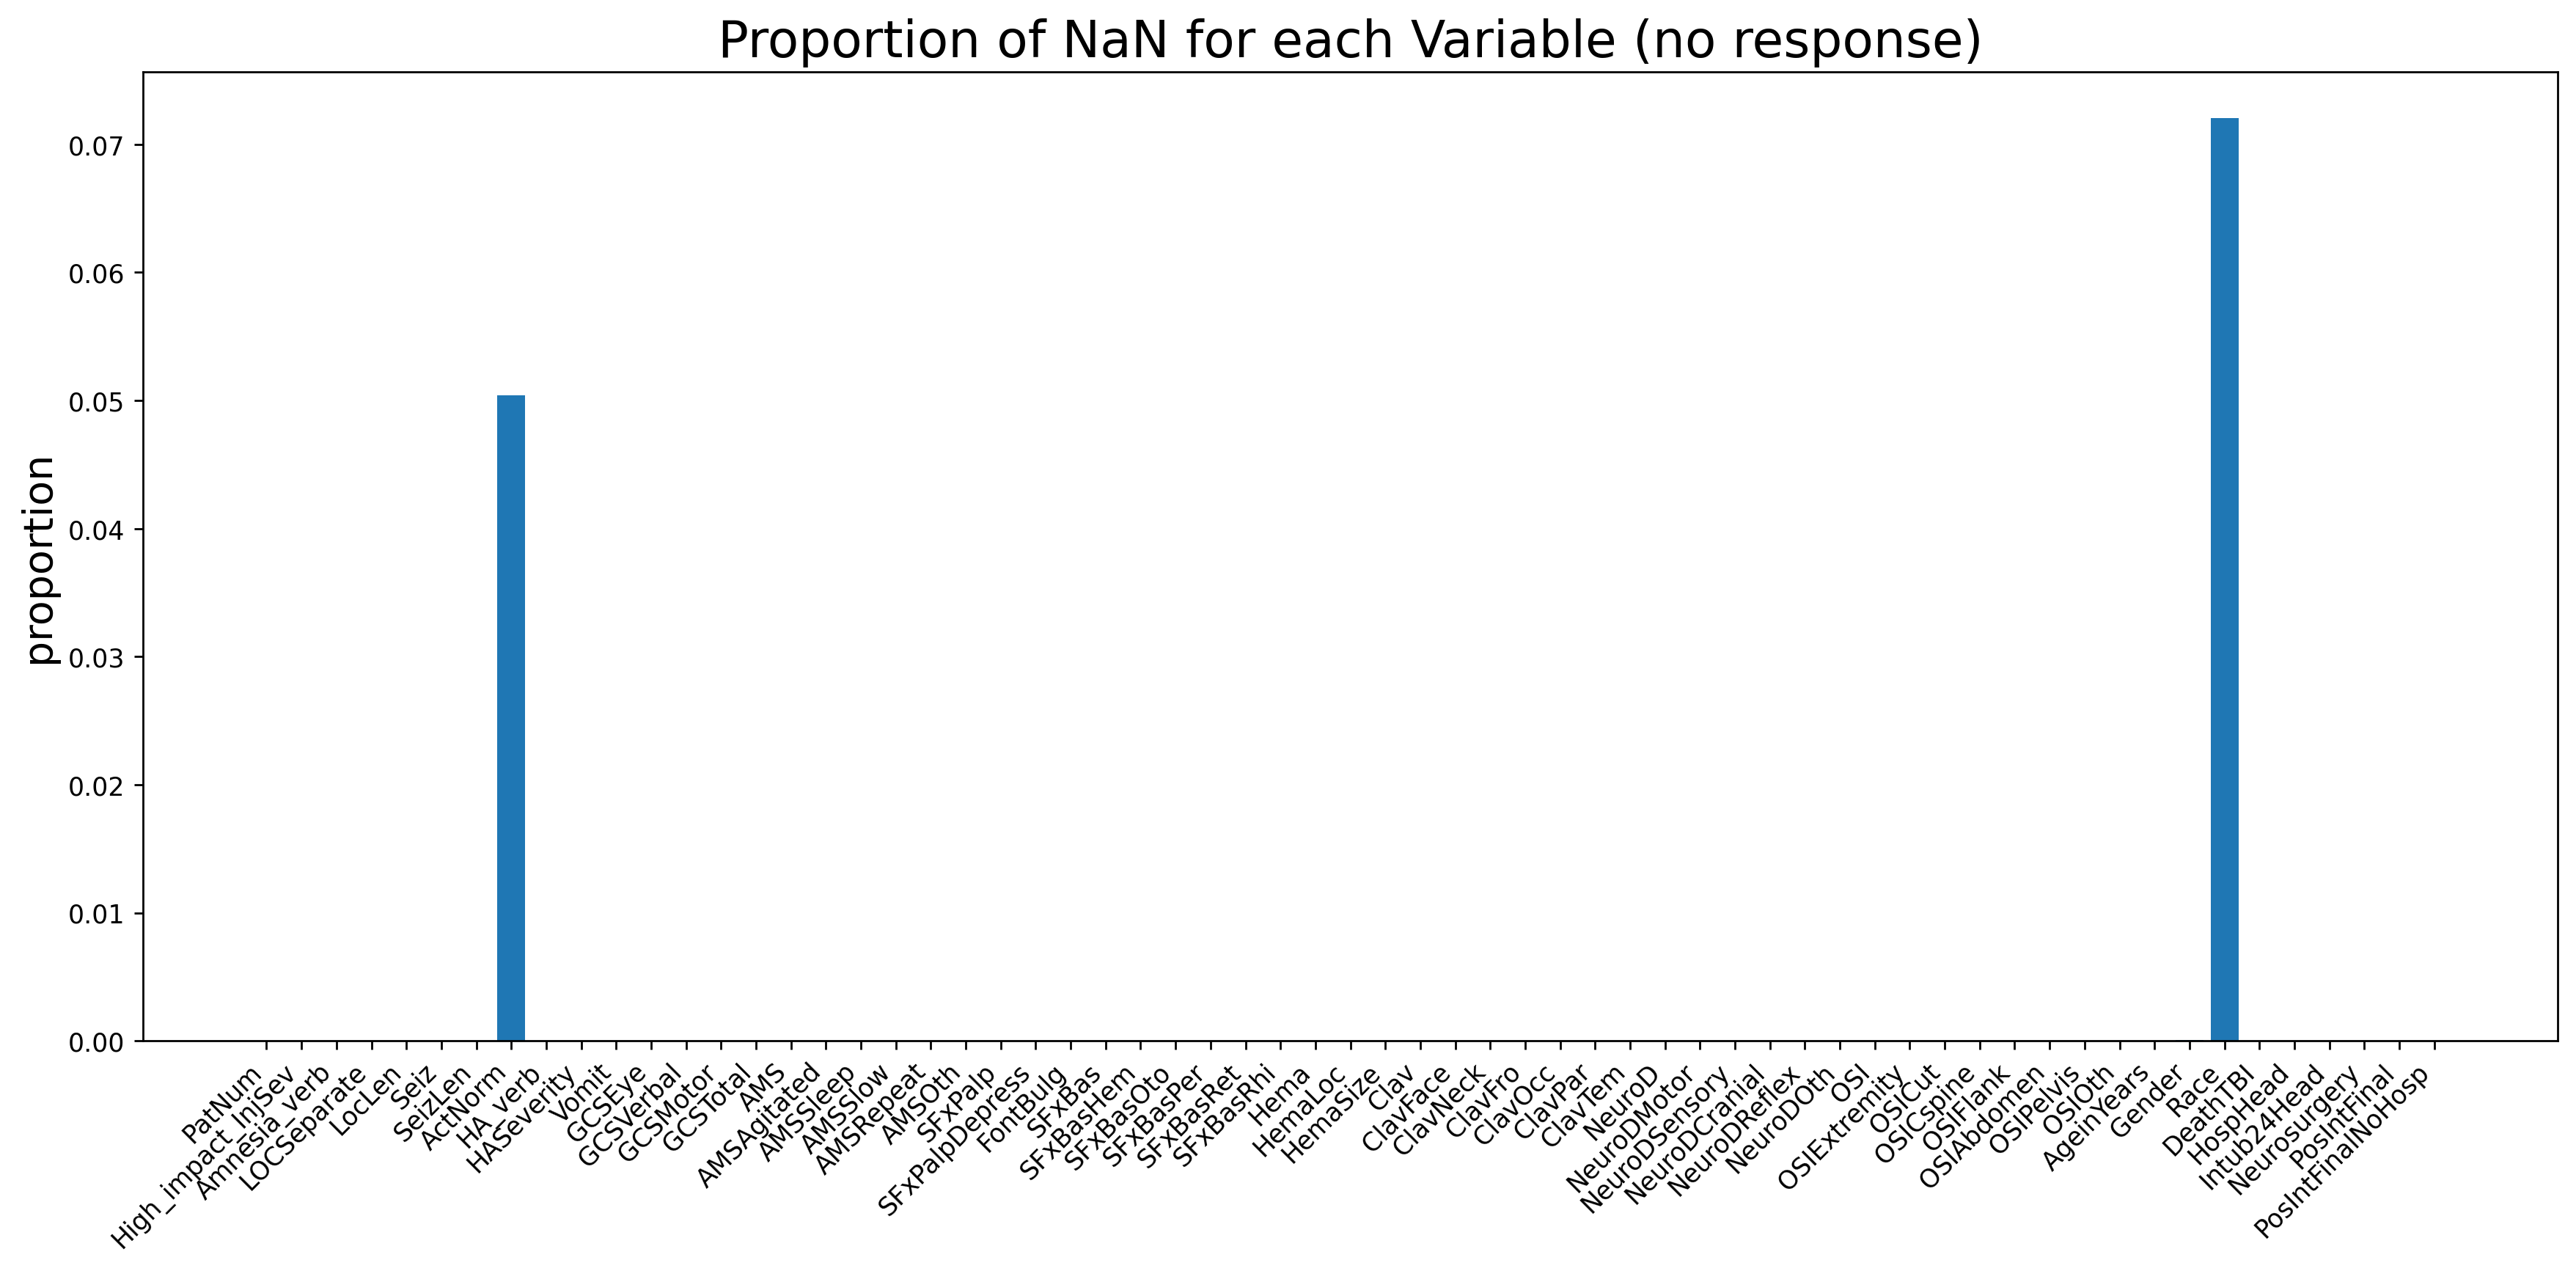

In [48]:
make_missing_plot(tbi_df_step20)

So, at this point, we've gotten rid of most of the missing values. I've left the missing values for Race and ActNorm, because these seem particularly important and may warrant some further investigation to decide what we should do. Otherwise, I still haven't dealt with the missing values that were labelled as 92, but after looking through the missing values so much in contingency tables, it seems like all of the 92 values are due to the umbrella variable being negative, as opposed to it being missing. So, we have to figure out how we might want to divide these variables (binarize, or just keep the binary umbrella variable)?

### To Do:

1. Document every variable and what they mean (since I changed up some of the encoding)
2. Figure out what to do with the remaining missigness and the recoding of the variables (binarizing everything, etc.)
3. Discuss/write down the possible perturbations to the judgment calls I could make, and bake that into the framework
4. Figure out how to integrate into the github framework
5. (possible: think of some other judgment calls?)